<div class="panel panel-primary" style="border-radius:0.8em">
    <div class="panel-heading" align="center">
        <span style="font-size:2em">Mordenising Managemant LTD.</span> <br>
        <b>Data Discovery and Machine Inteligence</b>
    </div>
    <div class="panel-body" style="font-size:2.2em" align="center">
        Employee Attrition Predictions
    </div>
</div>

In [1]:
import numpy as np
import pandas as pd
import pydbgen
import matplotlib.pylab as plt

from pydbgen import pydbgen
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report



<div class="alert alert-info" style="font-size:1.5em">
    Model Construction
</div>

In [2]:
def train_test_split(*arrays, test_size=None, train_size=None, random_state=None):
    length = len(arrays[0])
    if random_state:
        np.random.seed(random_state)
    p = np.random.permutation(length)

    if type(test_size) == int:
        index = length - test_size
    elif type(test_size) == float:
        index = length - np.ceil(length * test_size)
    else:
        if type(train_size) == int:
            index = train_size
        elif type(train_size) == float:
            index = int(length * train_size)
        else:
            index = length - np.ceil(length * 0.25)

    return [b for a in arrays for b in (a[p][:int(index)], a[p][int(index):])]

In [3]:
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))
sigmoid_gen = lambda x: (1+np.exp(-x))**-1


In [4]:
def log_likelihood(features, target, weights):
    scores = np.dot(features, weights)
    ll = np.sum( target*scores - np.log(1 + np.exp(scores)) )
    return ll

In [5]:
def logistic_regression(features, target, num_steps, learning_rate, max_iter, add_intercept = False):
    if add_intercept:
        intercept = np.ones((features.shape[0], 1))
        features = np.hstack((intercept, features))
        
    weights = np.zeros(features.shape[1])
    
    for step in range(num_steps):
        scores = np.dot(features, weights)
        predictions = sigmoid(scores)

        # Update weights with log likelihood gradient
        output_error_signal = target - predictions
        
        gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient
        
         # Print log-likelihood every so often
        if step % 10000 == 0:
            print (log_likelihood(features, target, weights))
        
    return weights

<div class="alert alert-info" style="font-size:1.5em">
    Data Exploration
</div>

In [6]:
df = pd.read_excel('WA_Fn-UseC_-HR-Employee-Attrition.xlsx')

In [7]:
myDB = pydbgen.pydb()
Names = myDB.gen_dataframe(len(df),['name'])
Names.columns = ['Employees_Names']
Names.head()

,Employees_Names
0,Henry Cunningham
1,Alex Love
2,Angela Ray MD
3,Timothy Jacobs
4,Peter Kelley


In [8]:
df = pd.concat([Names,df], axis=1)
df.head()

,Employees_Names,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,Henry Cunningham,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,...,1,80,0,8,0,1,6,4,0,5
1,Alex Love,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,...,4,80,1,10,3,3,10,7,1,7
2,Angela Ray MD,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,...,2,80,0,7,3,3,0,0,0,0
3,Timothy Jacobs,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,...,3,80,0,8,3,3,8,7,3,0
4,Peter Kelley,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,...,4,80,1,6,3,3,2,2,2,2


#### Convert the data frame to numeric using pandas

In [9]:
target_map = {'Yes':1, 'No':0}
df["Attrition_numerical"] = df["Attrition"].apply(lambda x: target_map[x])
target_map = {'Yes':1, 'No':0}
df["Attrition_numerical"] = df["Attrition"].apply(lambda x: target_map[x])

numerical = [u'Age', u'DailyRate',  u'JobSatisfaction',
       u'MonthlyIncome', u'PerformanceRating',
        u'WorkLifeBalance', u'YearsAtCompany', u'Attrition_numerical']


df2 = df.drop(['Attrition_numerical'], axis=1)

categorical_f = []
for col, value in df.iteritems():
    if value.dtype == 'object':
        categorical_f.append(col)

numerical_f = df2.columns.difference(categorical_f)

df2_cat = df[categorical_f]
df2_cat = df2_cat.drop(['Attrition'], axis=1) 
df2_cat = pd.get_dummies(df2_cat)
df3_num = df[numerical_f]

df_final = pd.concat([df3_num, df2_cat], axis=1)

target_map = {'Yes':1, 'No':0}
target = df["Attrition"].apply(lambda x: target_map[x])

X = df_final.values
y = target.values

<div class="alert alert-info" style="font-size:1.5em">
    Evaluation of the model
</div>

### Hypothesis

Risk for attrition rates increase is dependent on 
<ul>
    <li> <b>Frustration</b>
        <ol>
            <li> Earnings </li>
            <li> Time </li>
            <li> Line manager </li>
        </ol>
    </li>

    <li> <b>Progress</b>
        <ol>
            <li> Training </li>
            <li> Recognition </li>
            <li> Promorion </li>
        </ol>
    </li>
</ul>

$Frustration =\alpha*Earings + \beta*Time + \gamma*Progress$

#### market Value Estimate

In [10]:
def marketValueEstimate(employee, lst, numYears):
    relativeList = []

    for ind in lst:
        if employee['Department'] == ind['Department']:
            if employee['JobLevel'] == ind['JobLevel']:
                if abs(employee['YearsInCurrentRole'] - ind['YearsInCurrentRole']) <= numYears:
                    relativeList.append(float(ind['MonthlyIncome']))
                else:
                    relativeList.append(float(employee['MonthlyIncome']))
             
    if len(relativeList) > 0:
        return sum(relativeList)/len(relativeList)
    return float(employee['MonthlyIncome'])

In [74]:
def frustrationEstimate(employee, lst):
    frustrationEst = 20
    YearsAtComp  = employee['YearsAtCompany']
    interest, Distance    = 0, employee['DistanceFromHome']
    
    
    YearsAtCompany = employee['YearsAtCompany']
    if employee['DailyRate'] != employee['DailyRate']:
        progress = -1
    else:
        progress = 1
        
    progress *= YearsAtCompany              # if in good grounds with LM over time, satisfaction can be assumed.
    
    line_manager = progress
    time         = YearsAtComp * interest
    earnings     = (marketValueEstimate(employee, lst, 2) + float(employee['MonthlyIncome']))/2
    
    alpha, beta, gamma = .1, 2, 2 
    
    frustrationEst = earnings*alpha + time*beta + line_manager*gamma
    return frustrationEst;

In [75]:
def progressEstimate(employee):
    progressEst = 0
    promotions, Performance, training = employee['YearsSinceLastPromotion'], employee['PerformanceRating'], employee['TrainingTimesLastYear']
    score = employee['RelationshipSatisfaction']
    
    progressEst += promotions
    
    if score >= 2:
        if Performance > 0:
            if training > 0:
                if promotions > 0:
                    progressEst += 15
                else:
                    progressEst += 10
            else:
                progressEst += 10
        else:
            if training > 0:
                progressEst = 10
            else:
                progressEst = 1
    else:
        if Performance > 0:
            if training > 0:
                if promotions > 0:
                    progressEst += 12.5
                else:
                    progressEst += 10
            else:
                progressEst += 8
        else:
            if training > 0:
                progressEst = 10
            else:
                progressEst = 0
                
    return progressEst

In [76]:
def riskEstimate(employee, lst):
    risk = frustrationEstimate(employee, lst) + progressEstimate(elem)
    return risk

In [77]:
tmpList = []
for i in np.arange(len(df)):
    tmpList.append(df.loc[i])

In [79]:
dt = []

for elem in tmpList:
    dt.append([ marketValueEstimate(elem, tmpList, 3)])

dt = pd.DataFrame(dt)



In [84]:
dt.columns = ['MarketValueEst']
dt.head()

,MarketValueEst
0,5822.479167
1,5251.074733
2,2596.089862
3,2948.541475
4,2898.919355


In [86]:
result = pd.concat([df, dt], axis=1)
f_nal = pd.concat([result, Names], axis=1)
f_nal.columns

Index(['Employees_Names', 'Age', 'Attrition', 'BusinessTravel', 'DailyRate',
       'Department', 'DistanceFromHome', 'Education', 'EducationField',
       'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'Attrition_numerical', 'MarketValueEst', 'Employees_Names'],
      dtype='object')

In [27]:
sm = SMOTE(random_state=12, ratio = 0.7)
X_res, y_res = sm.fit_sample(df_final, target)
print("After OverSampling, counts of label '1': {}".format(sum(y_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res==0)))

After OverSampling, counts of label '1': 863
After OverSampling, counts of label '0': 1233


C:\Users\Dyke\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


#### Train and Test data_set

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0,random_state = 12)
print ('No: of zeor responses: %d' %sum(y_train == 0))
print ('No: of one responses: %d' %sum(y_train == 1))

No: of zeor responses: 1233
No: of one responses: 863


#### Over-sampling using smote

### MinMaxScaler

In [53]:
class MinMaxScaler(object):
    def __init__(self, feature_range=(0, 1)):
        self.low_, self.high_ = feature_range

    def fit(self, X):
        self.min_ = X.min(axis=0)
        self.max_ = X.max(axis=0)
        return self

    def transform(self, X):
        X_std = (X - self.min_) / (self.max_ - self.min_)
        return X_std * (self.high_ - self.low_) + self.low_

    def fit_transform(self, X):
        return self.fit(X).transform(X)
    
scaler = MinMaxScaler(feature_range=(0,1)).fit(X_train_res)
print(scaler.transform(X_train_res))

[[0.42857143 0.55977094 0.         ...        nan 1.         0.        ]
 [0.26190476 0.03006442 0.32142857 ...        nan 0.         1.        ]
 [0.78571429 0.85898354 0.03571429 ...        nan 1.         0.        ]
 ...
 [0.40197711 0.42352006 0.59739608 ...        nan 0.03898709 0.96101291]
 [0.4047619  0.40450399 0.60174108 ...        nan 0.         1.        ]
 [0.82955168 0.35402305 0.08487579 ...        nan 0.94705684 0.05294316]]


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


#### Calculating the weights for the input

In [44]:
weights = logistic_regression(X_train, y_train,
                     num_steps = 10000, learning_rate = 1.0e-8, max_iter=301, add_intercept=True)
print ("LOGISTIC REGRESSION FROM WEIGHTS => ",weights)

-409769.5790063176


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


LOGISTIC REGRESSION FROM WEIGHTS =>  [ 0.00383924  0.04573355 -0.01507029 ...  0.00383924 -0.01246868
  0.01630792]


#### Predictions

In [45]:
final_scores = np.dot(np.hstack((np.ones((X_train.shape[0], 1)),
                                 X_train)), weights)
preds = np.round(sigmoid(final_scores))
preds

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


array([1., 1., 1., ..., 1., 1., 1.])

#### Accuracy of the model

In [46]:
print ('Accuracy: {0}'.format((preds == y_train).sum().astype(float) / len(preds)))

Accuracy: 0.5229007633587787


#### Visualizations

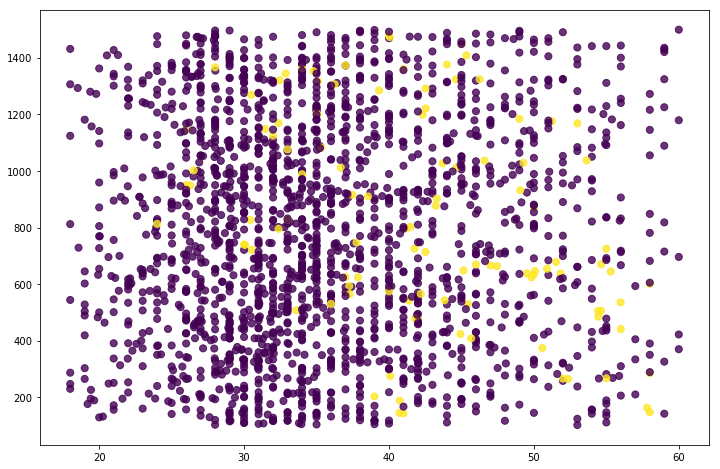

In [47]:
plt.figure(figsize = (12, 8))
plt.scatter(X_train[:, 0], X_train[:, 1],
            c = preds == y_train - 1, alpha = .8, s = 50)
plt.show()

In [48]:
target_names = ['class 0', 'class 1']
print(classification_report(y_train, preds, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.76      0.28      0.41      1233
    class 1       0.46      0.87      0.60       863

avg / total       0.64      0.52      0.49      2096



In [49]:
final_scores

array([376.6537518 , 367.35021237, 489.08870237, ..., 132.6858951 ,
        44.21373789, 551.6765301 ])

In [50]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train ) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [51]:
Likelihoods = logreg.predict_proba(X_train )
Likelihoods

array([[0.22396168, 0.77603832],
       [0.34784643, 0.65215357],
       [0.97127213, 0.02872787],
       ...,
       [0.8631296 , 0.1368704 ],
       [0.93980486, 0.06019514],
       [0.08919695, 0.91080305]])

In [72]:
df2 = pd.DataFrame(Likelihoods)

In [73]:
df2=df2[:len(df)] 

In [92]:
records = []
record = list(f_nal.columns)
record.extend(["LikelihoodToLeave", "LikelihoodToStay"])
records.append(record)

for i in range(len(f_nal)):
    record = list(f_nal.loc[i])
    record2 = list(df2.loc[i])
    record.extend(record2)
    records.append(record)

<div class="alert alert-info" style="font-size:1.5em">
    Saving the results
</div>

In [93]:
toFile = ""

for i in range(len(records)):
    for j in range(len(records[i])):
        if j != len(records[i]) - 1:
            toFile += str(records[i][j]) + ","
        else: toFile += str(records[i][j])
    toFile += "\n"

with open("rrrresults1.csv", "w") as writer:
    writer.write(toFile)
    writer.close()

In [94]:
csv = pd.read_csv('rrrresults1.csv')

In [95]:
csv.head()

,Employees_Names,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_numerical,MarketValueEst,Employees_Names.1,LikelihoodToLeave,LikelihoodToStay
0,Henry Cunningham,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,...,1,6,4,0,5,1,5822.479167,Henry Cunningham,0.223962,0.776038
1,Alex Love,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,...,3,10,7,1,7,0,5251.074733,Alex Love,0.347846,0.652154
2,Angela Ray MD,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,...,3,0,0,0,0,1,2596.089862,Angela Ray MD,0.971272,0.028728
3,Timothy Jacobs,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,...,3,8,7,3,0,0,2948.541475,Timothy Jacobs,0.093397,0.906603
4,Peter Kelley,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,...,3,2,2,2,2,0,2898.919355,Peter Kelley,0.427712,0.572288
